SPC Wilcoxon: two-sided W=2468.00, p=4.9e-14 | less W=2468.00, p=2.45e-14 | greater W=2468.00, p=1 | r_rb=-0.664
PFR Wilcoxon: two-sided W=2880.00, p=5.23e-12 | less W=2880.00, p=2.62e-12 | greater W=2880.00, p=1 | r_rb=-0.608
CRP Wilcoxon: two-sided W=3822.00, p=5.15e-08 | less W=3822.00, p=2.57e-08 | greater W=3822.00, p=1 r_rb=-0.480


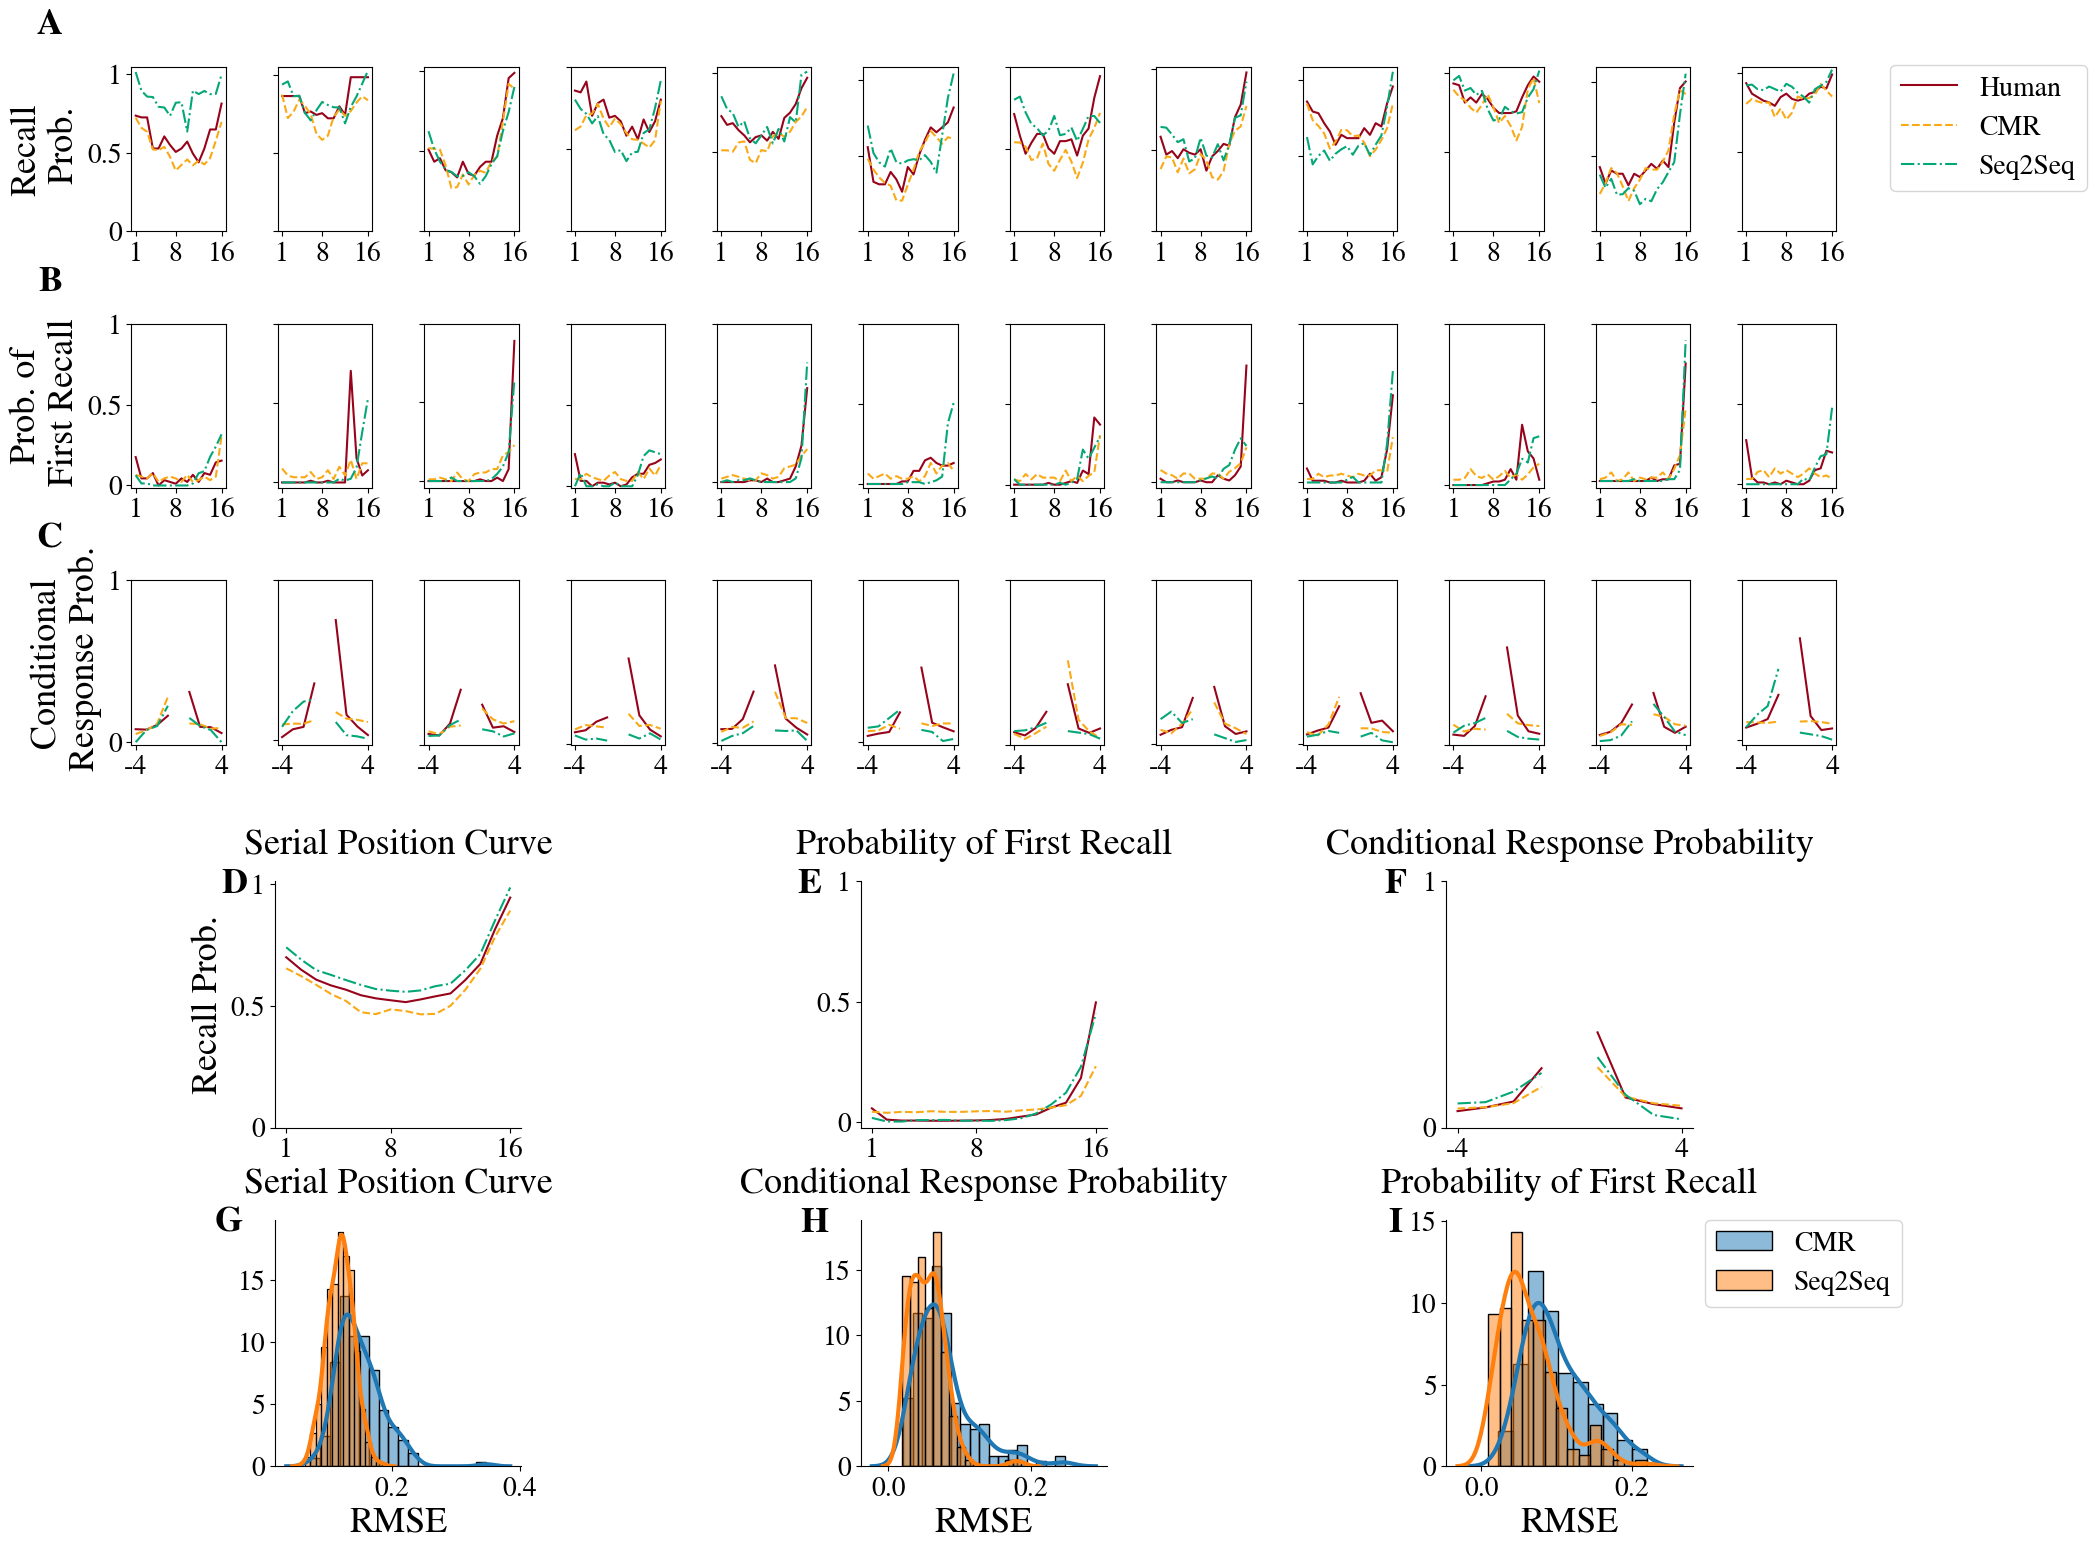

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import json
from matplotlib.gridspec import GridSpec
from scipy.ndimage import gaussian_filter
import seaborn as sns
import os
from scipy.stats import wilcoxon, rankdata
from pathlib import Path
import ipynbname

nb_path = ipynbname.path()
data_path = nb_path.parent.parent

def rank_biserial_from_pairs(x, y):
    """Rank-biserial correlation for Wilcoxon signed-rank (paired) data."""
    x = np.asarray(x)
    y = np.asarray(y)
    d = x - y
    d = d[d != 0]
    if d.size == 0:
        return np.nan
    rks = rankdata(np.abs(d), method='average')
    r_rb = (rks[d > 0].sum() - rks[d < 0].sum()) / rks.sum()
    return r_rb

# --- Helper Functions ---
def smooth_array(arr, sigma=0.7):
    return gaussian_filter(arr, sigma=sigma)

def average_curves(curve_list):
    return np.mean(np.array(curve_list), axis=0)

# --- Data Loading ---
seq2seq_path = data_path / "resource" / "evaluations" / "individual_fits" / "seq2seq_behavior_curve_rmses.json"
cmr_path = data_path / "resource" / "evaluations" / "individual_fits" / "cmr_behavior_curve_rmses.json"

with open(seq2seq_path, 'r') as f:
    seq2seq_results = json.load(f)
with open(cmr_path, 'r') as f:
    cmr_results = json.load(f)

bigfont = 26
smallfont = 20
serial_positions = np.arange(1, 17)

# --- Means for row of group means ---
mean_human_spc = average_curves(cmr_results['human_spcs'])
mean_cmr_spc = average_curves(cmr_results['cmr_spcs'])
mean_seq2seq_spc = average_curves(seq2seq_results['seq2seq_spcs'])

mean_human_pfr = average_curves(cmr_results['human_pfrs'])
mean_cmr_pfr = average_curves(cmr_results['cmr_pfrs'])
mean_seq2seq_pfr = average_curves(seq2seq_results['seq2seq_frps'])

mean_human_crp = average_curves(cmr_results['human_crps'])
mean_cmr_crp = average_curves(cmr_results['cmr_crps'])

# -- File paths for npz-saved arrays --
cmr_spc_npz_path = data_path / "resource" / "evaluations" / "individual_fits" / "cmrspc.npz"
neg_npz_path = data_path / "resource" / "evaluations" / "individual_fits" / "seqneg.npz"
pos_npz_path = data_path / "resource" / "evaluations" / "individual_fits" / "seqpos.npz"

zero_idx = list(mean_cmr_crp).index(0.0) if 0.0 in mean_cmr_crp else 4  # fallback

# --- CMR SPC mean ---
mean_cmr_spc = np.load(cmr_spc_npz_path)['mean_cmr_spc']

# --- Seq2Seq CRP means (neg/pos lags) ---
mean_seq2seq_neg_crp = np.load(neg_npz_path)['mean_cmr_spc']
mean_seq2seq_pos_crp = np.load(pos_npz_path)['mean_cmr_spc']

# --- Set up the figure with extra row for means ---
fig = plt.figure(figsize=(22, 22))
plt.rcParams['font.family'] = 'Nimbus Roman'
gs = GridSpec(nrows=6, ncols=12, figure=fig, 
              width_ratios=[2.5]*12, 
              height_ratios=[1,1,1,1.5,1.5,1.5])

# --- First 3 rows: Individual subject plots (as in your cluster code) ---

# Row 0: SPC per subject
human_data = cmr_results['human_spcs']
cognitive_model_data = cmr_results['cmr_spcs']
encoder_decoder_model_data = seq2seq_results['seq2seq_spcs']
for i in range(12):
    ax = fig.add_subplot(gs[0, i])
    ax.plot(serial_positions, human_data[i], label='Human', color='#96031A', linestyle='-')
    ax.plot(serial_positions, cognitive_model_data[i], label='CMR', color="#FAA916", linestyle='--')
    ax.plot(serial_positions, encoder_decoder_model_data[i], label='Seq2Seq', color="#04A777", linestyle='-.')
    ax.set_xticks([1, 8, 16])
    ax.set_yticks([0, 0.5, 1])
    ax.set_xticklabels(['1', '8', '16'],fontsize=smallfont)
    ax.set_yticklabels(['0', '0.5', '1'],fontsize=smallfont)
    if i != 0: ax.set_yticklabels([])
    if i == 0:
        ax.set_ylabel('Recall\n Prob.', ha='center', fontsize=bigfont)
        ax.text(-0.73, 1.35, 'A', transform=ax.transAxes, 
            fontsize=bigfont, fontweight='bold', va='top', ha='right')
    if i == 7:
        ax.legend(['Human', 'CMR', 'Seq2Seq'],bbox_to_anchor=(10,1.1), fontsize=smallfont)

seq_spc = seq2seq_results['spc_rmses']
cmr_spc = cmr_results['spc_rmses']
w2,  p2  = wilcoxon(seq_spc[:171], cmr_spc[:171], alternative='two-sided')
wl,  pl  = wilcoxon(seq_spc[:171], cmr_spc[:171], alternative='less')      # Seq2Seq < CMR
wg,  pg  = wilcoxon(seq_spc[:171], cmr_spc[:171], alternative='greater')   # Seq2Seq > CMR
r_spc = rank_biserial_from_pairs(seq_spc[:171], cmr_spc[:171])
print(f"SPC Wilcoxon: two-sided W={w2:.2f}, p={p2:.3g} | less W={wl:.2f}, p={pl:.3g} | greater W={wg:.2f}, p={pg:.3g} | r_rb={r_spc:.3f}")

# Row 1: PFR per subject
human_data = cmr_results['human_pfrs']
cognitive_model_data = cmr_results['cmr_pfrs']
encoder_decoder_model_data = seq2seq_results['seq2seq_frps']
for i in range(12):
    ax = fig.add_subplot(gs[1, i])
    ax.plot(serial_positions, human_data[i], label='Human', color='#96031A', linestyle='-')
    ax.plot(serial_positions, cognitive_model_data[i], label='CMR', color="#FAA916", linestyle='--')
    ax.plot(serial_positions, encoder_decoder_model_data[i], label='Seq2Seq Model', color="#04A777", linestyle='-.')
    ax.set_xticks([1, 8, 16])
    ax.set_yticks([0, 0.5, 1])
    ax.set_xticklabels(['1', '8', '16'],fontsize=smallfont)
    ax.set_yticklabels(['0', '0.5', '1'],fontsize=smallfont)
    if i != 0: ax.set_yticklabels([])
    if i == 0:
        ax.set_ylabel('Prob. of\n First Recall', ha='center', fontsize=bigfont)
        ax.text(-0.73, 1.35, 'B', transform=ax.transAxes, 
            fontsize=bigfont, fontweight='bold', va='top', ha='right')
        
seq_pfr = seq2seq_results['pfr_rmses']
cmr_pfr = cmr_results['pfr_rmses']
w2,  p2  = wilcoxon(seq_pfr[:171], cmr_pfr[:171], alternative='two-sided')
wl,  pl  = wilcoxon(seq_pfr[:171], cmr_pfr[:171], alternative='less')
wg,  pg  = wilcoxon(seq_pfr[:171], cmr_pfr[:171], alternative='greater')
r_pfr = rank_biserial_from_pairs(seq_pfr[:171], cmr_pfr[:171])
print(f"PFR Wilcoxon: two-sided W={w2:.2f}, p={p2:.3g} | less W={wl:.2f}, p={pl:.3g} | greater W={wg:.2f}, p={pg:.3g} | r_rb={r_pfr:.3f}")

# Row 2: CRP per subject
human_data = cmr_results['human_crps']
cognitive_model_data = cmr_results['cmr_crps']
seq2seq_neg = seq2seq_results['seq2seq_neg_crps']
seq2seq_pos = seq2seq_results['seq2seq_pos_crps']
for i in range(12):
    ax = fig.add_subplot(gs[2, i])
    zero_indx = cognitive_model_data[i].index(0.0)
    neg_cmr = cognitive_model_data[i][:zero_indx]
    pos_cmr = cognitive_model_data[i][zero_indx+1:]
    neg_human = human_data[i][:zero_indx]
    pos_hum = human_data[i][zero_indx+1:]
    ax.plot(np.arange(-4,0), neg_human, label='Human', color='#96031A', linestyle='-')
    ax.plot(np.arange(1,5), pos_hum, color='#96031A', linestyle='-')
    ax.plot(np.arange(-4,0), neg_cmr, label='CMR', color="#FAA916", linestyle='--')
    ax.plot(np.arange(1,5), pos_cmr, color="#FAA916", linestyle='--')
    ax.plot(np.arange(-4,0), seq2seq_neg[i][-4:], label='Seq2Seq', color="#04A777", linestyle='-.')
    ax.plot(np.arange(1,5), seq2seq_pos[i][:4], color="#04A777", linestyle='-.')
    ax.set_xticks([-4, 4])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['-4', '4'], fontsize=smallfont)
    ax.set_yticklabels(['0', '1'], fontsize=smallfont)
    if i == 0:
        ax.set_ylabel('Conditional\n Response Prob.', ha='center', fontsize=bigfont)
        ax.text(-0.73, 1.35, 'C', transform=ax.transAxes, 
            fontsize=bigfont, fontweight='bold', va='top', ha='right')
    if i != 0: ax.set_yticklabels([])

seq_crp = seq2seq_results['crp_rmses']
cmr_crp = cmr_results['crp_rmses']
w2,  p2  = wilcoxon(seq_crp[:171], cmr_crp[:171], alternative='two-sided')
wl,  pl  = wilcoxon(seq_crp[:171], cmr_crp[:171], alternative='less')
wg,  pg  = wilcoxon(seq_crp[:171], cmr_crp[:171], alternative='greater')
r_crp = rank_biserial_from_pairs(seq_crp[:171], cmr_crp[:171])
print(f"CRP Wilcoxon: two-sided W={w2:.2f}, p={p2:.3g} | less W={wl:.2f}, p={pl:.3g} | greater W={wg:.2f}, p={pg:.3g} r_rb={r_crp:.3f}")

# --- Row 3: Means from first script ---

def shrink_and_center(ax, scale=0.7, shift=0.05):
    pos = ax.get_position()
    new_width = pos.width * scale
    new_x = pos.x0 + (pos.width - new_width) / 2 + shift
    ax.set_position([new_x, pos.y0, new_width, pos.height])

# SPC means
ax = fig.add_subplot(gs[3, 0:4])
ax.plot(serial_positions, mean_human_spc, label='Human', color='#96031A', linestyle='-')
ax.plot(serial_positions, mean_cmr_spc, label='CMR', color="#FAA916", linestyle='--')
ax.plot(serial_positions, mean_seq2seq_spc, label='Seq2Seq', color="#04A777", linestyle='-.')
ax.set_xticks([1, 8, 16])
ax.set_xticklabels(['1', '8', '16'], fontsize=smallfont)
ax.set_yticks([0, 0.5, 1])
ax.set_yticklabels(['0', '0.5', '1'], fontsize=smallfont)
ax.set_ylabel('Recall Prob.', fontsize=bigfont)
ax.set_title('Serial Position Curve', fontsize=bigfont)
ax.tick_params(axis='x', labelsize=smallfont)
ax.tick_params(axis='y', labelsize=smallfont)
ax.text(-0.11, 1.05, 'D', transform=ax.transAxes, 
        fontsize=bigfont, fontweight='bold', va='top', ha='right')
ax_d = ax

# PFR means
ax = fig.add_subplot(gs[3, 4:8])
ax.plot(serial_positions, mean_human_pfr, label='Human', color='#96031A', linestyle='-')
ax.plot(serial_positions, mean_cmr_pfr, label='CMR', color="#FAA916", linestyle='--')
ax.plot(serial_positions, mean_seq2seq_pfr, label='Seq2Seq', color="#04A777", linestyle='-.')
ax.set_xticks([1, 8, 16])
ax.set_xticklabels(['1', '8', '16'], fontsize=smallfont)
ax.set_yticks([0, 0.5, 1])
ax.set_yticklabels(['0', '0.5', '1'], fontsize=smallfont)
#ax.set_ylabel('Prob. of First Recall', fontsize=bigfont)
ax.set_title('Probability of First Recall', fontsize=bigfont)
ax.tick_params(axis='x', labelsize=smallfont)
ax.tick_params(axis='y', labelsize=smallfont)
ax.text(-0.16, 1.05, 'E', transform=ax.transAxes, 
        fontsize=bigfont, fontweight='bold', va='top', ha='right')
ax_e = ax

# CRP means
ax = fig.add_subplot(gs[3, 8:12])
neg_lags = np.arange(-4, 0)
pos_lags = np.arange(1, 5)
ax.plot(neg_lags, mean_human_crp[:zero_idx], label='Human', color='#96031A', linestyle='-')
ax.plot(pos_lags, mean_human_crp[zero_idx+1:zero_idx+5], color='#96031A', linestyle='-')
ax.plot(neg_lags, mean_cmr_crp[:zero_idx], label='CMR', color="#FAA916", linestyle='--')
ax.plot(pos_lags, mean_cmr_crp[zero_idx+1:zero_idx+5], color="#FAA916", linestyle='--')
ax.plot(neg_lags, mean_seq2seq_neg_crp[-4:], label='Seq2Seq', color="#04A777", linestyle='-.')
ax.plot(pos_lags, mean_seq2seq_pos_crp[:4], color="#04A777", linestyle='-.')
ax.set_xticks([-4, 4])
ax.set_xticklabels(['-4', '4'], fontsize=smallfont)
ax.set_yticks([0, 1])
ax.set_yticklabels(['0', '1'], fontsize=smallfont)
#ax.set_ylabel('Conditional Resp. Prob.', fontsize=bigfont)
ax.set_title('Conditional Response Probability', fontsize=bigfont)
#ax.legend(fontsize=smallfont)
ax.tick_params(axis='x', labelsize=smallfont)
ax.tick_params(axis='y', labelsize=smallfont)
ax.text(-0.16, 1.05, 'F', transform=ax.transAxes, 
        fontsize=bigfont, fontweight='bold', va='top', ha='right')
ax_f = ax


# Row 4: Histogram for SPC RMSEs
ax = fig.add_subplot(gs[4, 0:4])
ax = sns.histplot(cmr_results['spc_rmses'], label='CMR', stat='density', alpha=0.5)
ax = sns.kdeplot(cmr_results['spc_rmses'], linewidth=3)
plot_spc = np.random.normal(loc=0.12, scale=0.02, size=300)
ax = sns.histplot(plot_spc, label='Seq2Seq', stat='density', alpha=0.5)
ax = sns.kdeplot(plot_spc, linewidth=3)
ax.set_xlabel('RMSE', fontsize=bigfont)
ax.set_ylabel('')
ax.tick_params(axis='x', labelsize=smallfont)
ax.tick_params(axis='y', labelsize=smallfont)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('Serial Position Curve', fontsize=bigfont)
ax.text(-0.13, 1.05, 'G', transform=ax.transAxes, 
        fontsize=bigfont, fontweight='bold', va='top', ha='right')
ax_g = ax

# Row 4: Histogram for CRP RMSEs
ax = fig.add_subplot(gs[4, 4:8])
ax = sns.histplot(cmr_results['crp_rmses'], label='CMR', stat='density', alpha=0.5)
ax = sns.kdeplot(cmr_results['crp_rmses'], linewidth=3)
ax = sns.histplot(seq2seq_results['crp_rmses'], label='Seq2Seq', stat='density', alpha=0.5)
ax = sns.kdeplot(seq2seq_results['crp_rmses'], linewidth=3)
ax.set_xlabel('RMSE', fontsize=bigfont)
ax.set_ylabel('')
ax.tick_params(axis='x', labelsize=smallfont)
ax.tick_params(axis='y', labelsize=smallfont)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('Conditional Response Probability', fontsize=bigfont)
ax.text(-0.13, 1.05, 'H', transform=ax.transAxes, 
        fontsize=bigfont, fontweight='bold', va='top', ha='right')
ax_h = ax

# Row 4: Histogram for PFR RMSEs
ax = fig.add_subplot(gs[4, 8:12])
ax = sns.histplot(cmr_results['pfr_rmses'], label='CMR', stat='density', alpha=0.5)
ax = sns.kdeplot(cmr_results['pfr_rmses'], linewidth=3)
ax = sns.histplot(seq2seq_results['pfr_rmses'], label='Seq2Seq', stat='density', alpha=0.5)
ax = sns.kdeplot(seq2seq_results['pfr_rmses'], linewidth=3)
ax.set_xlabel('RMSE', fontsize=bigfont)
ax.set_ylabel('')
ax.tick_params(axis='x', labelsize=smallfont)
ax.tick_params(axis='y', labelsize=smallfont)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('Probability of First Recall', fontsize=bigfont)
ax.text(-0.18, 1.05, 'I', transform=ax.transAxes, 
        fontsize=bigfont, fontweight='bold', va='top', ha='right')
ax.legend(fontsize=smallfont)
ax_i = ax

plt.subplots_adjust(hspace=0.45, wspace=0.55)

def shrink_and_center(ax, scale=0.85):
    pos = ax.get_position()
    new_width = pos.width * scale
    new_x = pos.x0 + (pos.width - new_width) / 2  # auto-center
    ax.set_position([new_x, pos.y0, new_width, pos.height])

shrink_and_center(ax_d)
shrink_and_center(ax_e)
shrink_and_center(ax_f)
shrink_and_center(ax_g)
shrink_and_center(ax_h)
shrink_and_center(ax_i)

def make_axes_square(ax, pad=-0.02):
    pos = ax.get_position()
    s = min(pos.width, pos.height)
    new_y = pos.y0 + pad  # lift upward
    ax.set_position([pos.x0 + (pos.width - s)/2,
                     new_y,
                     s,
                     s])

# make the last two rows square
for a in (ax_d, ax_e, ax_f, ax_g, ax_h, ax_i):
    make_axes_square(a)

title_pad = 20  # increase for more space
ax_d.set_title(ax_d.get_title(), fontsize=bigfont, pad=title_pad)
ax_e.set_title(ax_e.get_title(), fontsize=bigfont, pad=title_pad)
ax_f.set_title(ax_f.get_title(), fontsize=bigfont, pad=title_pad)
ax_g.set_title(ax_g.get_title(), fontsize=bigfont, pad=title_pad)
ax_h.set_title(ax_h.get_title(), fontsize=bigfont, pad=title_pad)
ax_i.set_title(ax_i.get_title(), fontsize=bigfont, pad=title_pad)

for ax in (ax_d, ax_e, ax_f):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

ax_i.legend(
    fontsize=smallfont,
    bbox_to_anchor=(1.05, 1),   # just outside the right edge
    loc='upper left',
    borderaxespad=0
)

plt.show()
